# Initialize a fresh test data dir

Includes horiz and vertical symmetry manipulations

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from numpy import asarray
import h5py
from glob import glob
import json
import sys
import random
import cv2
import PIL
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
data_dir = './dcai_gcb_05/dcai_gcb_05'
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
numerals = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]
save_frac = 0.2
target_counts = {
    'i': 250,
    'ii': 700,
    'iii': 700,
    'iv': 1700,
    'v': 800,
    'vi': 1000,
    'vii': 1400,
    'viii': 1500,
    'ix': 1400,
    'x': 500,
}
print(sum(target_counts.values()))
target_counts = {k: int((1-save_frac)*v) for k, v in target_counts.items()}
print(sum(target_counts.values()))

9950
7960


In [21]:
def get_file_count(numeral):
    num_pattern = data_dir + '/*/{}/*.png'.format(numeral)
    fps = glob(num_pattern)
    return len(fps)

def get_n_required(numeral):
    n_files = get_file_count(numeral)
    n_required = target_counts[numeral] - n_files
    return n_required

def count_all_files():
    n_tot = 0
    for n in numerals:
        n_files = get_file_count(n)
        n_tot += n_files
        print('Numeral "{}" has {} files'.format(n, n_files))
    print('Total of {} files'.format(n_tot))

In [5]:
count_all_files()

Numeral "i" has 320 files
Numeral "ii" has 200 files
Numeral "iii" has 201 files
Numeral "iv" has 330 files
Numeral "v" has 243 files
Numeral "vi" has 232 files
Numeral "vii" has 246 files
Numeral "viii" has 253 files
Numeral "ix" has 274 files
Numeral "x" has 232 files
Total of 2531 files


In [6]:
outliers = pd.read_csv('./outliers.csv', index_col=0)
outliers = outliers[(outliers.outlier == True)]
outliers['fp'] = [data_dir + '/train' + fp for fp in outliers['fp']]
outliers

,fp,label,outlier,class
3,./dcai_gcb_05/dcai_gcb_05/train/ii/ab2ddcea-ce...,outlier,True,ii
6,./dcai_gcb_05/dcai_gcb_05/train/ii/ab2fc7da-ce...,outlier,True,ii
16,./dcai_gcb_05/dcai_gcb_05/train/ii/ab38bd5e-ce...,outlier,True,ii
19,./dcai_gcb_05/dcai_gcb_05/train/ii/ab3b5726-ce...,outlier,True,ii
25,./dcai_gcb_05/dcai_gcb_05/train/ii/ab3f6550-ce...,outlier,True,ii
...,...,...,...,...
1445,./dcai_gcb_05/dcai_gcb_05/train/x/afe816a6-ce5...,outlier,True,x
1455,./dcai_gcb_05/dcai_gcb_05/train/x/afee9e86-ce5...,outlier,True,x
1458,./dcai_gcb_05/dcai_gcb_05/train/x/aff1a37e-ce5...,outlier,True,x
1473,./dcai_gcb_05/dcai_gcb_05/train/x/b000f5d6-ce5...,outlier,True,x


In [7]:
def run(fp_source, fp_dest, 
        horiz=False, 
        vert=False, 
        rotate=False, 
        erode=False,
        dilate=False,
        enhance=1, 
        contrast=1, 
        resize=(32, 32), 
        show=False):
    
    image = Image.open(fp_source)
    image_out = Image.open(fp_source)
    
    if rotate == 'random':
        rotate = np.random.normal(0, 12)
    if enhance == 'random':
        enhance = np.random.normal(1, 0.5)
    if contrast == 'random':
        contrast = np.maximum(0.3, np.random.normal(1, 0.5))
    if erode == 'random':
        erode = np.random.choice([0, 1], 1)
    if dilate == 'random':
        dilate = np.random.choice([0, 1], 1)

    if horiz:
        arr = asarray(image_out)
        arr = arr[:, ::-1]  # horizontal sym
        image_out = Image.fromarray(arr)
    if vert:
        arr = asarray(image_out)
        arr = arr[::-1, :]  # vert sym
        image_out = Image.fromarray(arr)
    if rotate:
        image_out = image_out.rotate(rotate, PIL.Image.NEAREST, 
                                     expand=False, 
                                     fillcolor='white')
    if erode:
        kernel = np.ones((3, 3), np.uint8)
        arr_out = cv2.erode(asarray(image_out), kernel, iterations=1)
        image_out = Image.fromarray(arr_out)
    if dilate:
        kernel = np.ones((2, 2), np.uint8)
        arr_out = cv2.dilate(asarray(image_out), kernel, iterations=1)
        image_out = Image.fromarray(arr_out)

    image_out = image_out.resize(resize)

    image_out = ImageEnhance.Sharpness(image_out)
    image_out = image_out.enhance(enhance)
    image_out = ImageEnhance.Contrast(image_out)
    image_out = image_out.enhance(contrast)

    if show:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        ax1.imshow(image, cmap='binary_r')
        ax2.imshow(image.resize(resize), cmap='binary_r')
        ax3.imshow(image_out, cmap='binary_r')
        plt.show()
        plt.close()

    if fp_dest is not None:
        image_out.save(fp_dest)

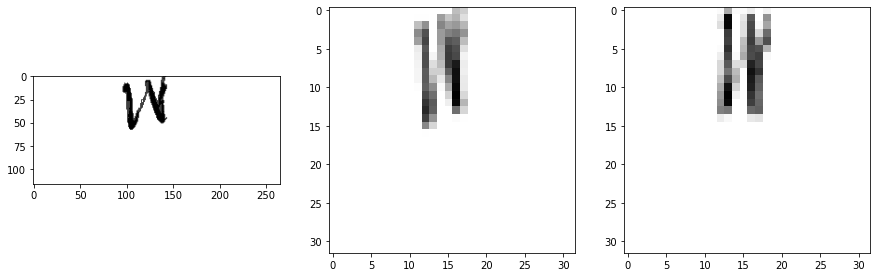

In [8]:
num = 'iv'
num_dir = data_dir + '/train/{}/*.png'.format(num)

# fps = [fp for fp in glob(num_dir) if '_vert' not in fp and '_horiz' not in fp]
fps = outliers.loc[(outliers['class'] == num), 'fp'].values

fp = fps[0]
fp_out = None
run(fp, fp_out, horiz=False, vert=False, 
    enhance='random', 
    contrast=1, 
    rotate='random', 
    erode='random', 
    dilate=False, 
    show=True)

In [9]:
ifile = 0
horiz_sym = ['i', 'ii', 'iii', 'x', 'v']
vert_sym = ['i', 'ii', 'iii', 'x', 'ix']
no_sym = ['vii', 'viii']

jobs = {
    'i': {'horiz': True, 'vert': True},
    'ii': {'horiz': True, 'vert': True},
    'iii': {'horiz': True, 'vert': True},
    'iv': {'horiz': False, 'vert': False, 'target': 'vi'},
    'v': {'horiz': True, 'vert': False},
    'vi': {'horiz': False, 'vert': False, 'target': 'iv'},
    'vii': {'horiz': False, 'vert': False},
    'viii': {'horiz': False, 'vert': False},
    'ix': {'horiz': False, 'vert': True},
    'x': {'horiz': True, 'vert': True},
}

In [10]:
for num, kwargs in jobs.items():
    n_required = get_n_required(num)
    num_dir = data_dir + '/train/{}/*.png'.format(num)
    if n_required < 0:
        fps = [fp for fp in glob(num_dir)]
        ifps = np.random.choice(np.arange(len(fps)), -n_required, replace=False)
        for i in ifps:
            fp = fps[i]
            os.remove(fp)
    else:
        fps = [fp for fp in glob(num_dir) if '_eng_' not in fp]
#         fps = outliers.loc[(outliers['class'] == num), 'fp'].values

        ifps = np.random.choice(np.arange(len(fps)), n_required, replace=True)
        for i in ifps:
            fp = fps[i]

            if 'target' in kwargs:
                target = kwargs.pop('target')
                base_dir = os.path.dirname(fp).replace(num, target)
                fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(target, str(ifile).zfill(5)))
            else:
                base_dir = os.path.dirname(fp)
                fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(num, str(ifile).zfill(5)))

            run(fp, fp_out, 
                enhance='random', 
                contrast=1, 
                rotate='random', 
                erode='random', 
                dilate=False, 
                show=False, 
                **kwargs)
            ifile += 1

In [11]:
count_all_files()

Numeral "i" has 200 files
Numeral "ii" has 560 files
Numeral "iii" has 560 files
Numeral "iv" has 1360 files
Numeral "v" has 640 files
Numeral "vi" has 799 files
Numeral "vii" has 1120 files
Numeral "viii" has 1200 files
Numeral "ix" has 1120 files
Numeral "x" has 400 files
Total of 7959 files


In [12]:
bad_images = ['./dcai_gcb_04/dcai_gcb_04/val/i/b178641c-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/i/b17c40b4-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/i/b17fe6d8-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/i/b1ac72d4-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/i/b1b0ab88-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b1448f7a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b146fb5c-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b149af64-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b159b1de-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b15d4984-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ii/b16ee8c4-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iii/b3582cc2-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iii/b35f78b0-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iii/b372aa02-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iii/b3776f9c-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b23a1a4e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b23ac48a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b2459a90-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b247068c-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b24bb114-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b24e9640-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b256c6f8-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/iv/b26b5366-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/v/b2ea2128-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b0fa893e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b1073b66-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b1152c12-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b1173f98-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b11b9e58-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b11cddea-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vi/b1223880-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1bc6fe0-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1bd4c44-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1cc3a7e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1cec9e2-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1d7b26e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1dfd34a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1e7e83c-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/vii/b1e9e34e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1f24142-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1f457de-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1f9edf2-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1fb28ca-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1fd2d64-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b1fe7de0-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b2030310-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b20adaea-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b20b6f82-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b20d7296-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b20f3da6-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b20fd680-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b210d9fe-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b2120a86-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b2147dc0-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b2152dd8-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b21ac90a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b21d4df6-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b21f0272-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b21fb6a4-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b2222c72-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b22aeb64-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/viii/b22e5844-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b27d3298-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b27ef3da-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b2803128-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b28218da-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b28fdb0a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b293d5ca-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b296cbae-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b2a7966e-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b2ab71ee-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b2ac89da-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/ix/b2b12fe4-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/x/b2f49e00-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/x/b2fcd502-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/x/b31ef10a-ce5d-11eb-b317-38f9d35ea60f.png',
              './dcai_gcb_04/dcai_gcb_04/val/x/b32511a2-ce5d-11eb-b317-38f9d35ea60f.png',
             ]

In [22]:
target_counts = {
    'i': 250,
    'ii': 700,
    'iii': 700,
    'iv': 1700,
    'v': 800,
    'vi': 1000,
    'vii': 1400,
    'viii': 1500,
    'ix': 1400,
    'x': 500,
}
sum(target_counts.values())

9950

In [23]:
for num, kwargs in jobs.items():
    n_required = get_n_required(num)
    num_dir = data_dir + '/train/{}/*.png'.format(num)
    if n_required < 0:
        fps = [fp for fp in glob(num_dir)]
        ifps = np.random.choice(np.arange(len(fps)), -n_required, replace=False)
        for i in ifps:
            fp = fps[i]
            os.remove(fp)
    else:
        print(num, n_required)
        fps = [fp for fp in bad_images if '/{}/'.format(num) in fp]
#         fps = [fp for fp in glob(num_dir) if '_eng_' not in fp]
#         fps = outliers.loc[(outliers['class'] == num), 'fp'].values

        ifps = np.random.choice(np.arange(len(fps)), n_required, replace=True)
        for i in ifps:
            fp = fps[i]

            if 'target' in kwargs:
                target = kwargs.pop('target')
                base_dir = os.path.dirname(fp).replace(num, target)
                base_dir = base_dir.replace()
                fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(target, str(ifile).zfill(5)))
            else:
                base_dir = os.path.dirname(fp)
                fp_out = os.path.join(base_dir, '{}_eng_{}.png'.format(num, str(ifile).zfill(5)))

            run(fp, fp_out, 
                enhance='random', 
                contrast=1, 
                rotate='random', 
                erode='random', 
                dilate=False, 
                show=False, 
                **kwargs)
            ifile += 1

i 50
ii 140
iii 140
iv 340
v 160
vi 201
vii 280
viii 300
ix 280
x 100


In [24]:
count_all_files()

Numeral "i" has 200 files
Numeral "ii" has 560 files
Numeral "iii" has 560 files
Numeral "iv" has 1360 files
Numeral "v" has 640 files
Numeral "vi" has 799 files
Numeral "vii" has 1120 files
Numeral "viii" has 1200 files
Numeral "ix" has 1120 files
Numeral "x" has 400 files
Total of 7959 files
